# OTMF demonstration notebook

This is the jupyter Notebook demonstration associated to the repository github.com/courbot/otmf.

Author : Jean-Baptiste Courbot

Website & contact informations: http://www.jb-courbot.fr/

This code is a prototype. If something is unclear or if you spot a bug, feel free to contact me !

**************************************

When using these codes, please cite :
Courbot, J. B., Monfrini, E., Mazet, V.  & Collet, C. (2018). Oriented Triplet Markov Fields. Pattern Recognition Letters, 103, 16-22.

See README.md for licence & setup informations.

### Imports

In [2]:
import numpy as np 
import sys 
import matplotlib.pyplot as plt
import matplotlib.image as im
import time
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


from scipy.ndimage import zoom
from scipy.ndimage.filters import gaussian_filter 
from scipy.ndimage.filters import median_filter 

% matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
from otmf import parameters
from otmf import gibbs_sampler as gs
from otmf import fields_tools as ft
import otmf.segmentation as sot
from otmf import parameter_estimation as pe

### Misc functions (display, etc)

In [4]:
def plot_directions(angle,pas,taille=1):
    
    S0 = angle.shape[0]
    S1 = angle.shape[1]
    
    y,x = np.ogrid[0:S0,0:S1]
 
    angle2 = angle

    deb_x = np.tile(x,(S0,1)) - taille*np.sin(angle2) 
    deb_y = np.tile(y,(1,S1)) - taille*np.cos(angle2) 
    
    fin_x = np.tile(x,(S0,1)) + taille*np.sin(angle2) 
    fin_y = np.tile(y,(1,S1)) + taille*np.cos(angle2) 
    
    
    for i in range(int(pas/2.),S0,pas):
        for j in range(int(pas/2.),S1,pas):
                plt.plot((deb_x[i,j],fin_x[i,j]), (deb_y[i,j],fin_y[i,j]) ,'k',linewidth=1)
    plt.xlim((-0.5,S1-0.5))
    plt.ylim((-0.5,S0-0.5))     
def plot_taux(im,ref,title):
    
    taux = (im!=ref).mean() * 100
    plt.imshow(im.T,  interpolation='nearest', origin='lower', cmap=plt.cm.bone,); 
    plt.title(title + ' - %.2f'%taux)
    plt.axis('off')
    
def calc_error(A,B):
    return (A[~np.isnan(B)] != B[~np.isnan(B)] ).mean()

### Data loading

In [5]:
def gen_exp(experiment,S0,S1,sig):
    
    print('Experiment '+experiment)

    if experiment=='A': # here v is fixed, and x is a realization of p(X|V=v)
        
        print('Here, v is fixed, and x is a realization of p(X|V=v).')

        dat = np.load('./data/expA.npz') # this path is relative to the position of demo.ipynb in the repo
        X=(dat['X'] > 0)[:S0,:S1]

        V = np.pi/4 * np.ones(shape=(S0,S1))
        V[64:,:] = 3*np.pi/4
        V[:,64:] = (V[:,64:] + np.pi/2)%np.pi
        
    elif experiment=='B':

        dat = np.load('./data/expB.npz')
        X=(dat['X']>0).astype(float)
        V=dat['V']
            
        print('Here, v and x come from a simulation from p(X,V).')

    Y = np.zeros(shape=(S0,S1,1))
    Y[:,:,0] = X + np.random.normal(loc=0.,scale=sig,size=(S0,S1))

    return X[:S0,:S1],V[:S0,:S1],Y[:S0,:S1,:]



##### Here you chose the image to process then load it.

In [6]:
# Choose the experiment ('A' or 'B')
experiment = 'B'

# choose the image size (up to 128x128 px for the proposed experiments) 
S0 = S1 = 128


# What orientations do we search for, sampled between 0 and pi.
v_range = np.array([np.pi/4, 3*np.pi/4])
# note : using 0 or pi is not recommended as it creates 0-valued potential functions which unbalance the processing.

# What classes do we search for X:
x_range = np.array([0.,1.])

# A parameter class gathering the previous informations (among others, see source).
pargibbs = parameters.ParamsGibbs(S0 = S0,
                             S1 = S1,
                             v_range = v_range,
                             x_range = x_range
                             )# beta=1.25,

# Now to generate the image, we set the standard deviation from the SNR.
SNR = 7 # in dB

sig = 1./10**(SNR/20.) # this expression must be modified if you use k>2 classes.

# X, V, Y are retrieved from data (for X,V) and simulated (for Y).
X,V,Y = gen_exp(experiment,S0,S1,sig)

# We add this image as a field of pargibbs.
pargibbs.Y = Y



Experiment B
Here, v and x come from a simulation from p(X,V).


### Data display 

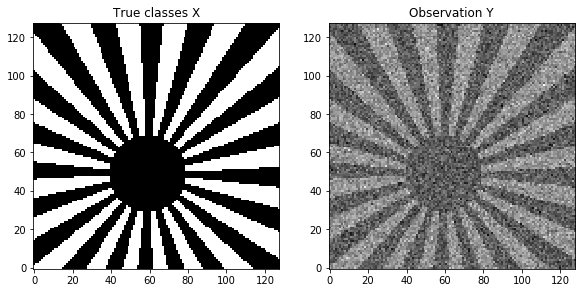

In [7]:
plt.figure(figsize=(15,5))

if experiment=='A':
    plt.subplot(131) ; plt.imshow(V,cmap=plt.cm.inferno,vmin=0,vmax=np.pi,alpha=0.5); plt.title('Orientations V')
    plot_directions(V,8,2)
# Indeed, in experiment B there is no "ground truth" for the orientations V.    
    
plt.subplot(132) ; plt.imshow(X); plt.title('True classes X')
plt.subplot(133) ; plt.imshow(Y[:,:,0]); plt.title('Observation Y')

plt.show()

## HMF segmentation

In [ ]:

parseg = parameters.ParamsSeg()

parseg.mpm = True #MPM [true] or MAP [False] segmentation.
parseg.tmf = False
pargibbs = parameters.apply_parseg_pargibbs(parseg,pargibbs) 


print '---------------HMF---------------------'
start = time.time()

X_hmf,_,Ux_hmf,_, parsem_hmf = sot.seg_otmf(parseg,pargibbs)

## 
end = time.time() - start
print 'Time : %.2f s'%end  
print '------------------------------------'
#

### Displaying the result

In [ ]:
error = calc_error(X,X_hmf)
error = min(error, 1-error)

plt.figure(figsize=(10,10))

plt.subplot(221) ; plt.imshow(X); plt.title('True classes X')
plt.subplot(222) ; plt.imshow(Y[:,:,0]); plt.title('Observation Y')
plt.subplot(223) ; plt.imshow(X_hmf); plt.title('Segmentation of x : %.2f / 100 '%(100*error))
if parseg.mpm:
    plt.subplot(224) ; plt.imshow(Ux_hmf,vmin=0,vmax=1); plt.title('Uncertainties on x (high: black, low:white)')
plt.show()

## OTMF segmentation

In [ ]:
###==============================================================================
### Segmentation OTMF
#####==============================================================================
parseg.tmf = True
pargibbs = parameters.apply_parseg_pargibbs(parseg,pargibbs) # transfetrt a l'autre jeu de parametre
print '---------------OTMF--------------------'
start = time.time()


X_otmf,V_otmf,Ux_otmf,Uv_otmf, parsem_otmf = sot.seg_otmf(parseg,pargibbs)

## 
end = time.time() - start
print 'Time : %.2f s'%end  
print '------------------------------------'

In [ ]:
error = calc_error(X,X_otmf)
error = min(error, 1-error)

plt.figure(figsize=(15,15))

if experiment=='A':
    plt.subplot(331) ; plt.imshow(V,cmap=plt.cm.inferno,vmin=0,vmax=np.pi,alpha=0.5); plt.title('Orientations V')
    plot_directions(V,8,2)
plt.subplot(332) ; plt.imshow(X); plt.title('True classes X')
plt.subplot(333) ; plt.imshow(Y[:,:,0]); plt.title('Observation Y')

plt.subplot(334)
plt.imshow(V_otmf,cmap=plt.cm.inferno,vmin=0,vmax=np.pi,alpha=0.5); plt.title('Orientations V')
plot_directions(V_otmf,8,2)
plt.subplot(335) ; plt.imshow(X_otmf); plt.title('Segmentation of x : %.2f / 100 '%(100*error))

plt.subplot(337); plt.imshow(Uv_otmf,vmin=0,vmax=1); plt.title('Uncertainties on v (high: black, low:white)')
plt.subplot(338); plt.imshow(Ux_otmf,vmin=0,vmax=1); plt.title('Uncertainties on v (high: black, low:white)')

plt.show()